<a id="toc_section"></a>
## Table of Contents
* [Extract] (#extract)
* [Introduction](#top_section)
    - [Well... What do we have here?](#section1)
* [Exploring the Data](#section2)
    - [Categorical Features](#section3)
    - [Numerical Features](#section4)
    - [Missing Values](#section5)    
* [Building the Feature Engineering Machine](#section6)
* [Double Check](#section24)
    - [Correlation Matrix](#section25)
* [Modelling](#section26)
    - [Model Selection](#section27)
    - [Cross-Validate Models](#section28)
    - [Model Results](#section29)
    - [ROC'S of the Models](#section30)
    - [Learning Curves of the Models](#section31)
* [Feature Selection](#section31.1)
    - [Feature Importances](#section32)
    - [Decision Trees](#section33)    
    - [Feature Selection by Recursive Feature Elimination](#section34)
    - [Dimension Reduction by Principal Component Analysis](#section35)
    - [Reduced Dimension Model Results with Cross-Validation](#sectioncv)
* [Plotting Decision Boundaries](#section36)
* [Plotting Decision Regions](#section37)
* [Submission & Some Last Words](#sectionlst)

<a id="Extract"></a>
# 1. Extract

<a id="top_section"></a>
# 2. Introduction



### My main objectives on this project are:

* Explorating and visualising the data, trying to get some insights about our dataset
* Getting data in better shape by feature engineering to help us in building better models
* Building and tuning couple regression models to get some stable results on predicting Titanic disaster outcome

### In this notebook we are going to try explore the data we have and going try answer questions like:

- What is the ditribution of Sale Price in the training data
- What are the categorical and continuous attributes of the data set?
- Which attributes are too focused on one attributes?

<a id="section1"></a>
# 3. Loading and Exploring the data


### [Back To Table of Contents](#toc_section)

## 3.1 Loading Required Libraries and Shared Functions

In [106]:
# Importing neccesary packages.

import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from scipy import interp, stats
import math
from scipy.stats import norm

from pprint import pprint
import random


import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings

def plot_category(y_field, x_field:str="SalePrice"):
    sns.set(style="ticks", color_codes=True)
    g = sns.catplot(x=x_field, y=y_field, data=train_data);
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)


def get_color(existing_color=[])->str:
    r = lambda: random.randint(0,255)
    _color = '#%02X%02X%02X' % (r(),r(),r())
    _ = get_color(existing_color) if _color in existing_color else _color
    existing_color.append(_)
    return _

def plot_with_category(x_field:str, y_field:str='SalePrice'):
    y = train_data[y_field]
    x = pd.get_dummies(train_data[x_field])
    category = list(set(x.columns))
#     print(category, data_fields[x_field]["components"])
    chosen_color = []

    for c in category:
        # Plot outputs
        plt.scatter(x[c], y,  color=get_color(chosen_color))
        plt.title(label=f'{y_field} with respect to {data_fields[x_field]["components"][c.upper()]}')
#         plt.title(label=f'{y_field} with respect to {c}')
        # plt.plot(x, y, color='blue', linewidth=3)
        plt.show()

def pure_plot(x_field:str, y_field:str='SalePrice'):
    # Plot outputs
    plt.scatter(train_data[x_field], train_data[y_field],  color=get_color())
#     plt.plot(x, y, color='blue', linewidth=3)
    plt.show()
    
import time
def plot(x_field:str, y_field:str='SalePrice'):
#     print(f'Field: {x_field}\nDescription: {data_fields[x_field]["description"]}')
#     print('Components\n', *list(f'- {i}: {j}\n' for i,j in data_fields[x_field]['components'].items()))
    plot_category(x_field=y_field, y_field=x_field) if is_string_dtype(train_data[x_field]) else pure_plot(x_field, y_field)

def plot_dist_and_saleprice(attr,figsize=(10, 5),  **kwargs):
    f, (ax1, ax2,) = plt.subplots(1, 2, figsize=figsize, **kwargs)
    value_counts = all_data[attr].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts, hue_order=value_counts.index, ax=ax1)
    sale_price = all_data.groupby(attr).SalePrice.median()
    sale_price = sale_price[value_counts.index]
    sns.barplot(x=sale_price.index, y=sale_price, ax=ax2)
    return (ax1, ax2)
    
def plot_heap_map_corr(data:pd.DataFrame, save:bool=True):

    # import matplotlib.pyplot as plt
    sns.set(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)

    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure <- for adjust the size
    f, ax = plt.subplots(figsize=(40, 40))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    h_map = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,annot=True)
    if save:
        h_map.figure.savefig("correlation.png")
        
        
warnings.filterwarnings('ignore') # Disabling warnimgs for clearer outputs
pd.options.display.max_columns = 100 # Pandas option to increase max number of columns to display
pd.options.display.max_rows = 100
plt.style.use('ggplot') # Setting default plot style


In [107]:
# Read train and test data from csv files for visualization

train_data = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')


## 3.2 Data size and structure

Ok we have two sets(train and test) data and in total 2219 observations 80 features. Our target is SalePrice column which is not present on the test set(duh!)... 

For the rest we gonna inspect them individually soon but  generally speaking they look mostly categorical data with some continuous values like YearBuilt and Fireplaces.


In [108]:
# Checking train and test sets
display(train_data.sample(3))
display(test_data.sample(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
588,589,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,5,8,1968,2003,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Gd,GLQ,1324,Unf,0,113,1437,GasA,Ex,Y,SBrkr,1473,0,0,1473,2,0,1,0,1,1,Ex,5,Typ,2,Gd,Attchd,1968.0,Unf,1,452,TA,TA,Y,0,48,0,0,60,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000
157,158,60,RL,92.0,12003,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,2Story,8,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,BrkFace,84.0,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,0,774,774,GasA,Ex,Y,SBrkr,774,1194,0,1968,0,0,2,1,4,1,Ex,8,Typ,1,Gd,BuiltIn,2009.0,Fin,3,680,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,New,Partial,269500
1253,1254,60,RL,NaN,17542,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,2Story,7,7,1974,2003,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,Gd,LwQ,125,ALQ,1031,36,1192,GasA,TA,Y,SBrkr,1516,651,0,2167,1,0,2,1,3,1,Gd,9,Typ,2,Gd,Attchd,1974.0,RFn,2,518,TA,TA,Y,220,47,0,0,0,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,294000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1195,2656,60,RL,120.0,13975,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,525.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1090.0,1090.0,GasA,Ex,Y,SBrkr,1117,1089,0,2206,0.0,0.0,2,1,4,1,Ex,10,Typ,1,Gd,BuiltIn,2005.0,Fin,3.0,670.0,TA,TA,Y,148,95,0,0,0,0,NaN,NaN,NaN,0,8,2006,New,Partial
327,1788,30,RL,90.0,5400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,2,5,1940,1950,Gable,CompShg,Stucco,Stucco,None,0.0,Fa,TA,PConc,Fa,TA,No,Unf,0.0,Unf,0.0,416.0,416.0,GasA,Gd,N,FuseA,599,0,0,599,1.0,0.0,1,0,2,1,Gd,4,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,81,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
1155,2616,20,RL,85.0,10533,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1956,1956,Hip,CompShg,VinylSd,VinylSd,BrkFace,244.0,TA,Gd,CBlock,TA,TA,No,Rec,773.0,Unf,0.0,235.0,1008.0,GasA,TA,Y,SBrkr,1024,0,0,1024,1.0,0.0,1,0,2,1,Gd,5,Typ,2,TA,Attchd,1956.0,Unf,1.0,313.0,TA,TA,Y,0,0,0,0,280,0,NaN,NaN,NaN,0,8,2006,WD,Normal


# 4 Eploring Important Attritubes

## 4.1 The response variables; SalePrice

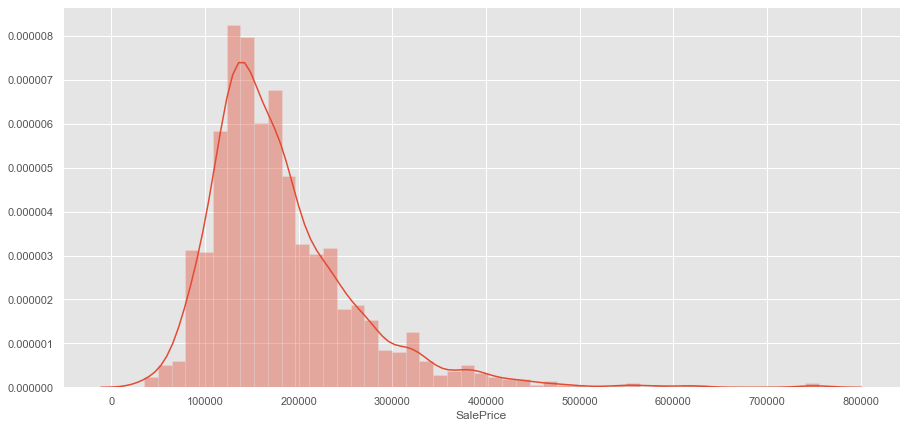

In [109]:
count = train_data['SalePrice'].value_counts(ascending=True)

f, ax = plt.subplots(figsize=(15, 7))

sns.distplot(train_data['SalePrice'], ax=ax) 

In [110]:
display( train_data['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


To get a general idea on the distribution of our targeted output.

As show on the statistics, the avearage distribution lie on around 160,000. The lower and upper quartile is at 130,000 and 214,000 respectively.

 (c&p)This was expected as few people can afford very expensive houses. 

In [111]:
# Merging visualization datasets.

def basic_data_set_info(train_data, test_data):
    num_train_data = train_data.shape[0]
    num_test_data = test_data.shape[0]
    print(f'Total record is {num_train_data+num_test_data}')
    print(f'Training set is {num_train_data}')
    print(f'Testing set is {num_test_data}')
    all_data = train_data.append(test_data,sort=False, ignore_index=True)
    print(f'Number of duplication (by id) is {all_data.shape[0] - len(set(all_data.Id))}')
    print(f'Number of features (except target prediction value): {all_data.shape[1]-1}')
    # 
    features = list(all_data.columns)
    features.remove('Id')
    features.remove('SalePrice')
    missing = (all_data[features].isnull().sum()/all_data[features].isnull().count()).sort_values(ascending=False)
    missing = pd.DataFrame({'Missing – NA(%)':round(missing[missing>0]*100,2)})
    print(missing.head(n=100))
    print(f'\n{missing.shape[0]} features have missing data')
#     missing_quant = (all_data[quantity].isnull().sum()/data_all[quantity].isnull().count()).sort_values(ascending=False)
#     missing_quant = missing_quant[missing_quant > 0] * 100
#     print("There are {} quantitative features with  missing values :".format(missing_quant.shape[0]))
#     missing_quant = pd.DataFrame({'Percent' :missing_quant})
#     missing_quant.head()
    return all_data.copy()

all_data = basic_data_set_info(train_data, test_data)
display(all_data.info())

Total record is 2919
Training set is 1460
Testing set is 1459
Number of duplication (by id) is 0
Number of features (except target prediction value): 80
              Missing – NA(%)
PoolQC                  99.66
MiscFeature             96.40
Alley                   93.22
Fence                   80.44
FireplaceQu             48.65
LotFrontage             16.65
GarageCond               5.45
GarageQual               5.45
GarageYrBlt              5.45
GarageFinish             5.45
GarageType               5.38
BsmtCond                 2.81
BsmtExposure             2.81
BsmtQual                 2.77
BsmtFinType2             2.74
BsmtFinType1             2.71
MasVnrType               0.82
MasVnrArea               0.79
MSZoning                 0.14
BsmtHalfBath             0.07
Utilities                0.07
Functional               0.07
BsmtFullBath             0.07
BsmtFinSF2               0.03
BsmtFinSF1               0.03
Exterior2nd              0.03
BsmtUnfSF                0.03
TotalBs

None

<a id="section2"></a>
# Numeric Attritubes

We get a first glimpse to the correlation of all numeric attritubes with SalePrice the response variable.

In [112]:
# numeric_vars = train_data.apply()
# display(train_data.d_type)

numeric_vars = train_data.select_dtypes(include=['int64', 'float64'])
# numeric_vars = pd.concat([numeric_vars['SalePrice'], numeric_vars[:-1]])
# numeric_attritubes = numeric_vars.columns.values
numeric_attritubes = list(numeric_vars)
numeric_attritubes.insert(0, numeric_attritubes.pop(numeric_attritubes.index('SalePrice')))

# reorder column SalePrice to the front
numeric_vars = numeric_vars[numeric_attritubes]


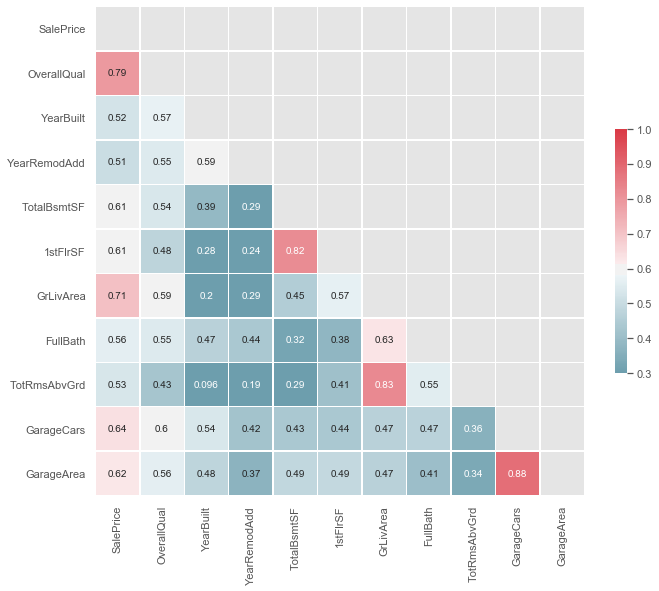

In [113]:
corr = numeric_vars.corr()
# display(corr)
corr = corr.loc[corr['SalePrice']>0.5, corr['SalePrice']>0.5]
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.3, vmax=1, center=0.6, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From all the numeric values, ony 10 numeric attributes has a corrleation higher than 0.5 with the saleprice

As seen from the first column, OverallQual has the highest correlation with the SalePrice. The second is GrLiveArea

We can see that there is 2919 entries in total with 80 features

In [114]:
# Checking merged shape
display(all_data.shape)

(2919, 81)

<a id="section3"></a>
## Categorical Features


In [115]:
# Selecting categorical data for univariate analysis
cats = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
        'SaleCondition'
       ]


def plotFrequency(cats):
    #"A plot for visualize categorical data, showing both absolute and relative frequencies"
    fig, axes = plt.subplots(math.ceil(len(cats) / 2), 2, figsize=(20,12))
    axes = axes.flatten()

    for ax, cat in zip(axes, cats):
        if cat == 'Survived':
            total = float(len(train_data[cat]))
        else:
            total = float(len(all_data[cat]))
        sns.countplot(all_data[cat], palette='plasma', ax=ax)

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

        plt.ylabel('Count', fontsize=15, weight='bold')

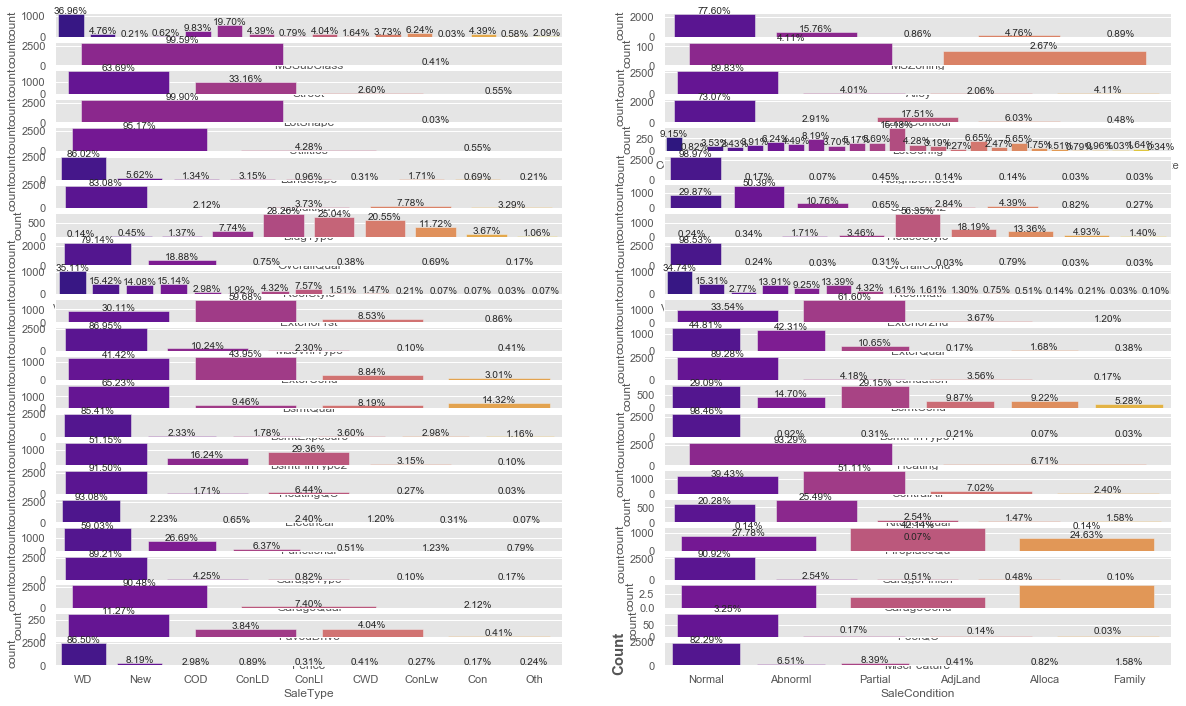

In [116]:
plotFrequency(cats)

<a id="section5"></a>
## 5. Missing Values

**Observations:**
- PoolQC,MiscFeature,Alley, Fence have the most missing values
- NaN values may represent None as a categorical attritubes

### [Back To Table of Contents](#toc_section)

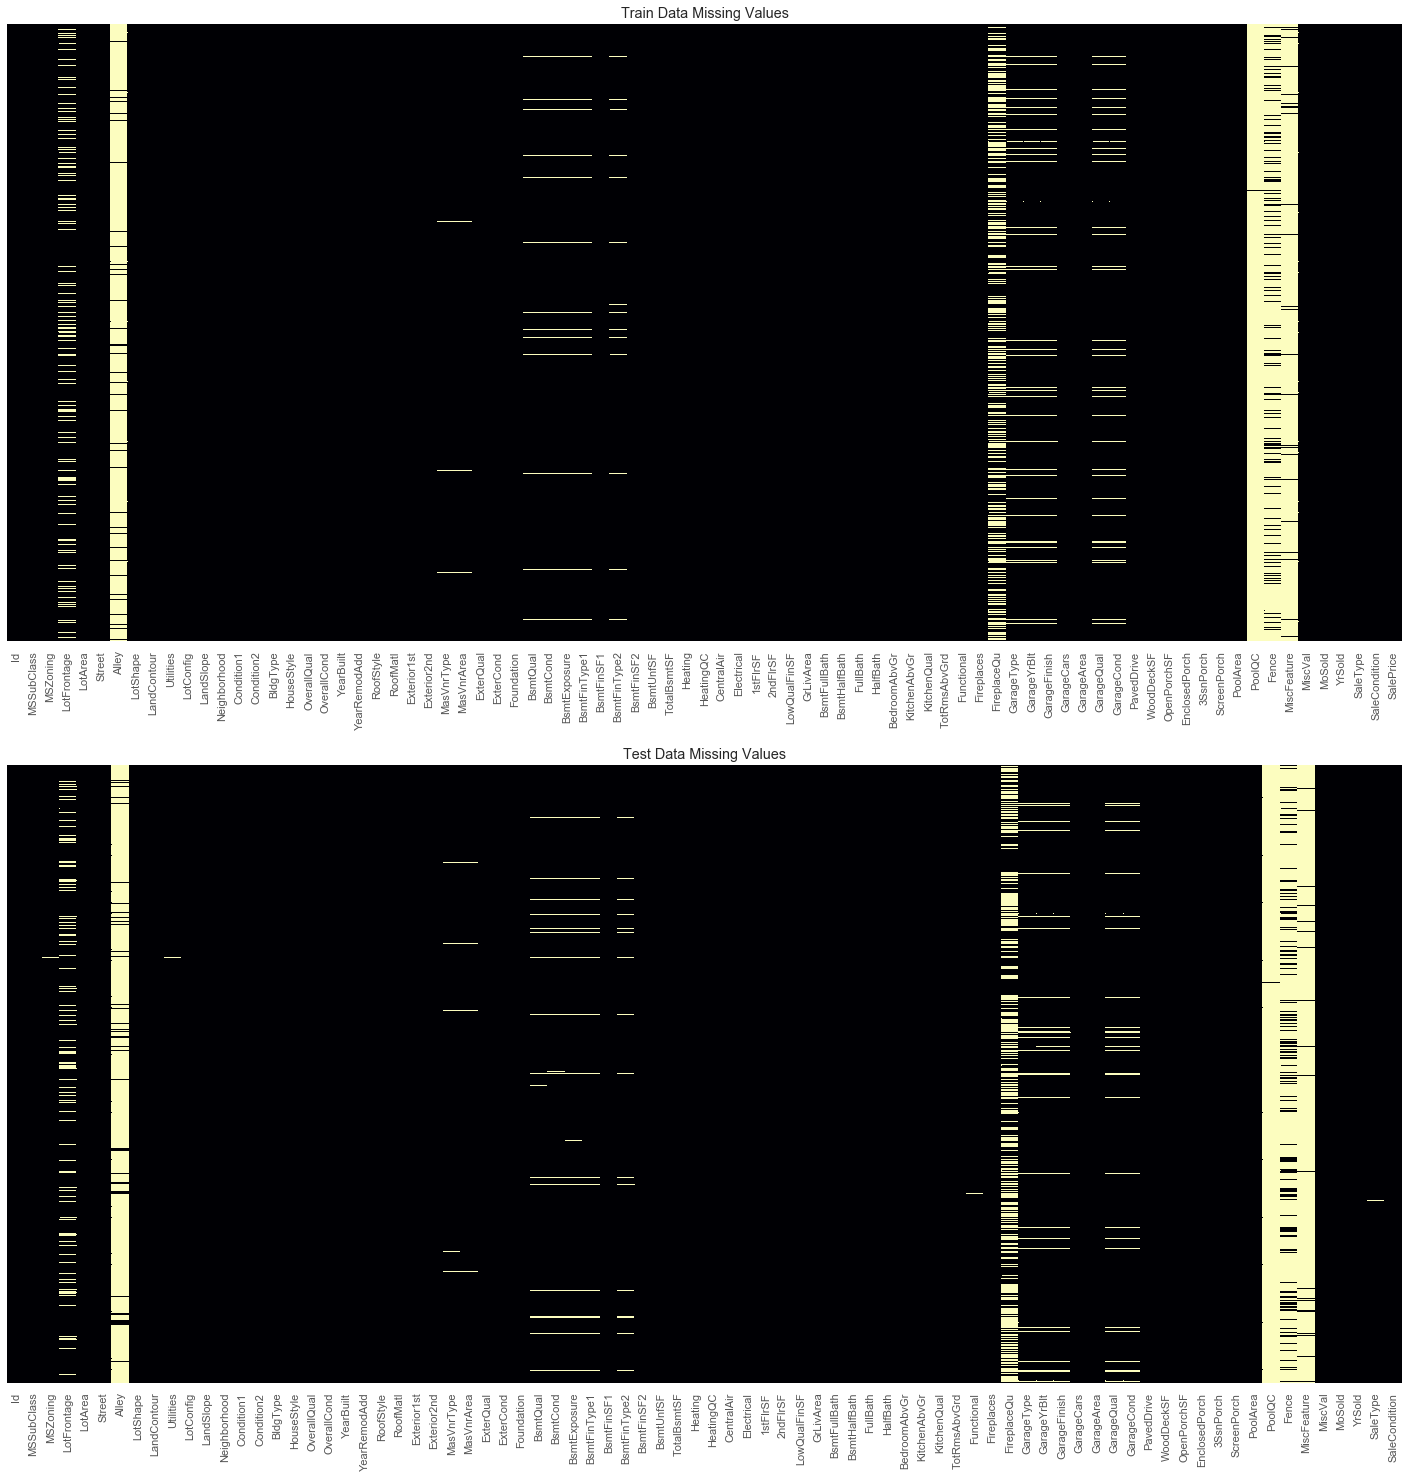

In [117]:
# Visualising missing data

fig, ax = plt.subplots(nrows=2, figsize=(25, 25))
half = len(train_data)/2
sns.heatmap(train_data.loc[:half].isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[0])
sns.heatmap(test_data.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='magma',
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

plt.xticks(rotation=90)
plt.show()

In [118]:
# Make Table to see NA values and class in total data set

def get_na_and_d_type(column):
    num_na = column.isnull().sum()
    dtype = column.dtype
    sample =column.sample(n=4).reset_index( drop=True)
    data_1= pd.Series({'number of missing data': num_na,'data type': dtype})
    return pd.concat([data_1, sample, ], )

all_data_na = all_data.apply(get_na_and_d_type, axis=0)
# all_data_na = all_data_na.loc[all_data_na['number of missing data'] != 0]
# display(all_data_na) 
display(all_data_na.T) 

# all_data_na_sorted = all_data_na.sort_values(by='number of missing data', axis=1, ascending=False)
# display(all_data_na_sorted) 

,number of missing data,data type,0,1,2,3
Id,0,int64,2328,1254,2283,2210
MSSubClass,0,int64,60,85,30,60
MSZoning,4,object,RL,RM,RL,RL
LotFrontage,486,float64,60,70,100,64
LotArea,0,int64,10005,11358,12155,47007
Street,0,object,Pave,Pave,Pave,Pave
Alley,2721,object,NaN,NaN,NaN,NaN
LotShape,0,object,Reg,IR1,IR1,Reg
LandContour,0,object,Lvl,Lvl,Lvl,Lvl
Utilities,2,object,AllPub,AllPub,AllPub,AllPub


**Observations:**
- PoolQC,MiscFeature,Alley, Fence have the most missing values
- NaN values may represent None as a categorical attritubes

In [119]:
all_data_na_top = all_data.apply(lambda column: column.isnull().sum(), axis=0).sort_values(ascending=False).head(30)
all_data_na_top

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageArea         1
BsmtFinSF2         1
Exterior1st        1
TotalBsmtSF        1
GarageCars         1
BsmtUnfSF          1
dtype: int64

## 5.1 Dealing with Missing data

Inputing missing values



In [120]:
# Share Functions
def convert_to_ordinary(all_data, order_val, field):
    print(f'{field} values: {set(all_data[field].values)}')
    valmap = {v:i for i,v in enumerate(order_val)}
    all_data[field] = all_data[field].replace(valmap)
    return all_data[field]

def fillna_by_mode(all_data, field:str):
    return all_data[field].fillna(all_data[field].mode().iloc[0])

## 5.1.1 MSZoning and Other Categorical Values

There is four missing data. The values are categorical. There is not other variables in common nature to infer the missing values.


Assign mode to the missing value, in condition that: 
* If the distribution of one group is dominant and
* The distribution of different group is comparable



```
    MSZoning
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
```       
       

In [121]:
all_data.loc[all_data.MSZoning.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,NaN
2216,2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,NaN
2250,2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal,NaN
2904,2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,NaN


RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

MSZoning
C (all)     74700.0
FV         205950.0
RH         136500.0
RL         174000.0
RM         120500.0
Name: SalePrice, dtype: float64

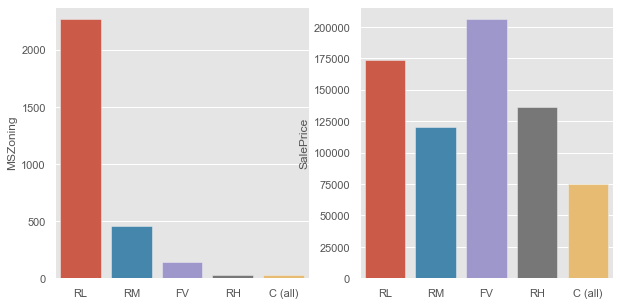

In [122]:
plot_dist_and_saleprice('MSZoning')    
display(all_data['MSZoning'].value_counts())

MSZoning_mode = all_data['MSZoning'].mode()
sale_price = all_data.groupby('MSZoning').SalePrice.median()
display(sale_price)

In [123]:
all_data['MSZoning'] = fillna_by_mode(all_data, field='MSZoning')

## 5.1.1.2 Other Categorical Attributes

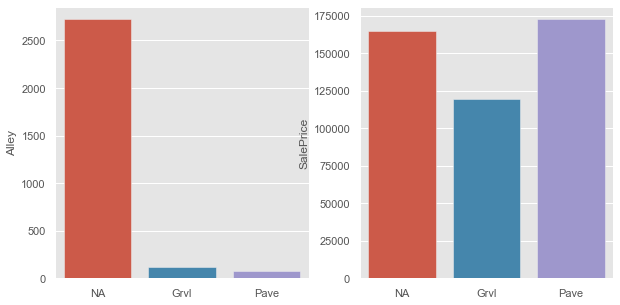

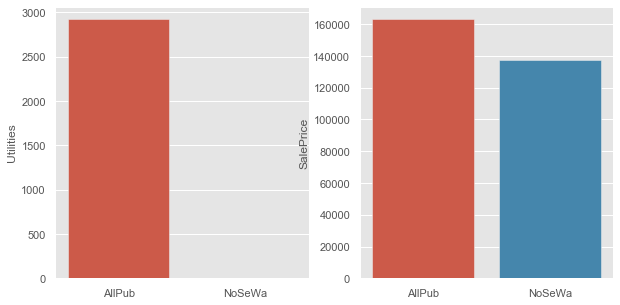

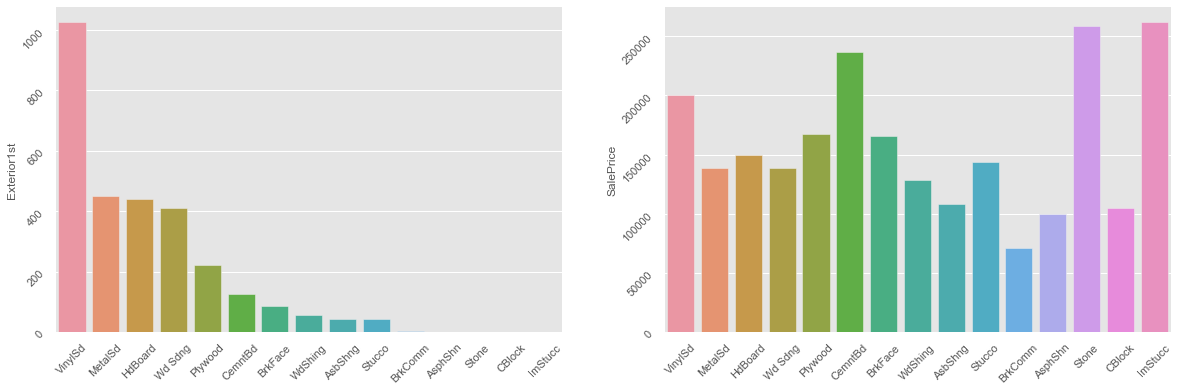

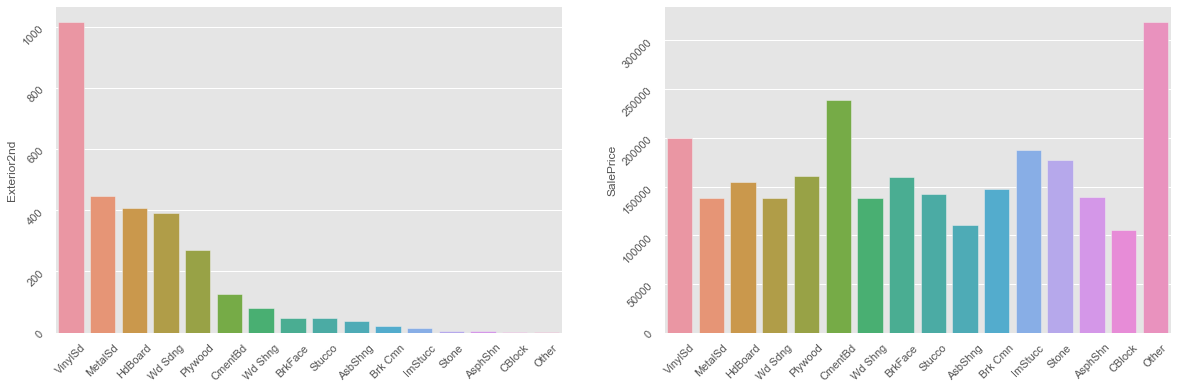

In [124]:
#Alley
all_data['Alley'] = all_data['Alley'].fillna('NA')
plot_dist_and_saleprice('Alley' )


#Utilities
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub')
plot_dist_and_saleprice('Utilities' )

# Exterior1st
mode_value = pd.concat([all_data['Exterior1st'], all_data['Exterior2nd']]).mode()
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(mode_value[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(mode_value[0])
(ax1, ax2) = plot_dist_and_saleprice('Exterior1st', figsize=(20, 6))
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
(ax1, ax2) = plot_dist_and_saleprice('Exterior2nd', figsize=(20, 6) )
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

We assign the mode of the attributes to the NA values

## 5.1.2 LotFrontage and Other Numeric values

486 NAs. Linear feet of street connected to property

We assign the NA to zero.



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


(array([0. , 0.5, 1. ]), <a list of 0 Text xticklabel objects>)

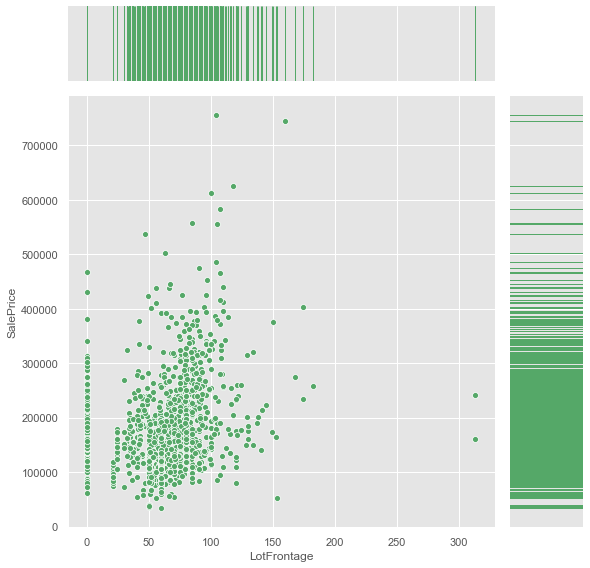

In [125]:
# f,ax1 = plt.subplots(figsize =(20,10))
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(0)
display(all_data.loc[all_data['LotFrontage'].isnull()])
data = all_data[['LotFrontage', 'SalePrice']]

grid = sns.JointGrid(x='LotFrontage',y='SalePrice',data=data, height =8)
grid.plot_joint(sns.scatterplot, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")
plt.xticks(rotation=90)

There is not a strong relationship with the SalePrice

In [126]:
all_data[['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.209624
SalePrice,0.209624,1.000000


We assign the NA to zero

## 5.1.3 Masonry veneer

MasVnrType should be closed related to MasVnrArea

MasVnrType has 24 NAs, MasVnrArea has 23 NAs. The two values should coexist to describe both the Masonry veneer type and area.

       MasVnrType: Masonry veneer type
   
       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
       
       
       MasVnrArea: Masonry veneer area in square feet

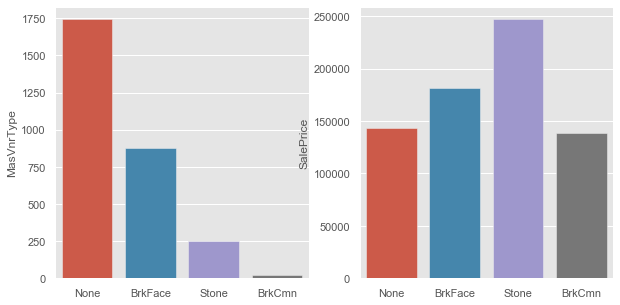

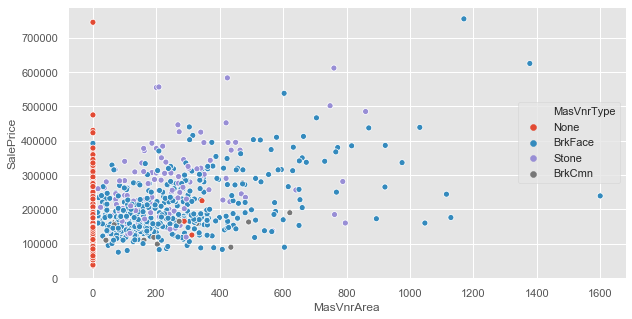

In [127]:


plot_dist_and_saleprice('MasVnrType')
masVnrType_data  = all_data[['MasVnrType', 'MasVnrArea','SalePrice']]

f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(x="MasVnrArea", y="SalePrice", hue="MasVnrType", hue_order=all_data.MasVnrType.value_counts().index,
                     data=masVnrType_data, ax=ax)


In [128]:
abnormal_data = all_data.loc[all_data.MasVnrType.isnull() & all_data.MasVnrArea.notnull() ]
abnormal_data

# all_data.loc[all_data.MasVnrType.isnull() & all_data.MasVnrArea.notnull() ].replace()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2610,2611,20,RL,124.0,27697,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,TA,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,NaN,NaN,NaN,0,11,2007,COD,Abnorml,NaN


The abnormal data has MasVnrArea = 198.0 and MasVnrType in Nan. We shall asign MasVnrType as the mode of the dataset except None, i.e. BrkFace.

In [129]:
## TODO: modify the abnormal_data


## Fill NA with 'None'
all_data['MasVnrType'].fillna('None', inplace=True)
all_data['MasVnrArea'].fillna(0, inplace=True)



## 5.1.4 Basement Variables

There are in total 11 basement related variables. 5 variables with 79 ~ 82 missing values, 6 variables with 1 to 2 missing values.

We check if the missing values belong to the same datasets.

    BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
    BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
    BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
    BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
    BsmtFinSF1: Type 1 finished square feet

    BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

    BsmtFinSF2: Type 2 finished square feet

    BsmtUnfSF: Unfinished square feet of basement area

    TotalBsmtSF: Total square feet of basement area
    
    BsmtFullBath: Basement full bathrooms

    BsmtHalfBath: Basement half bathrooms
    
   


In [130]:
basement_vars = [
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'
]

display(all_data[basement_vars].isnull().sum())


BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
dtype: int64

We check if the missing values belong to the same datasets.

In [131]:
bsmt_null = all_data[
    all_data['BsmtQual'].isnull() &
    all_data['BsmtCond'].isnull() &
    all_data['BsmtExposure'].isnull() &
    all_data['BsmtFinType1'].isnull() &
    all_data['BsmtFinType2'].isnull()
]

display(bsmt_null.shape)

(79, 81)

these 79 data 

In [132]:
## TODO: Assign the 79 to NA

basements_na_values_mapping = {
    'BsmtQual': 'NA',
    'BsmtCond': 'NA',
    'BsmtExposure': 'NA',
    'BsmtFinType1': 'NA',
    'BsmtFinType2': 'NA'
}

# Fill NAs of the 79 datasets 
all_data[
    all_data['BsmtQual'].isnull() &
    all_data['BsmtCond'].isnull() &
    all_data['BsmtExposure'].isnull() &
    all_data['BsmtFinType1'].isnull() &
    all_data['BsmtFinType2'].isnull()
] = all_data[
    all_data['BsmtQual'].isnull() &
    all_data['BsmtCond'].isnull() &
    all_data['BsmtExposure'].isnull() &
    all_data['BsmtFinType1'].isnull() &
    all_data['BsmtFinType2'].isnull()
].fillna(value=basements_na_values_mapping
       )

display(all_data[basement_vars].isnull().sum())




BsmtQual        2
BsmtCond        3
BsmtExposure    3
BsmtFinType1    0
BsmtFinSF1      1
BsmtFinType2    1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
dtype: int64

In [133]:
data_Bsmt = all_data[basement_vars]

                        
display(data_Bsmt.loc[all_data.BsmtQual.isna()])
display(data_Bsmt.loc[all_data.BsmtCond.isna()])
display(data_Bsmt.loc[all_data.BsmtExposure.isna()])
display(data_Bsmt.loc[all_data.BsmtFinSF1.isna()])
display(data_Bsmt.loc[all_data.BsmtFinSF2.isna()])
display(data_Bsmt.loc[all_data.BsmtFinType2.isna()])
display(data_Bsmt.loc[all_data.BsmtUnfSF.isna()])
display(data_Bsmt.loc[all_data.TotalBsmtSF.isna()])
display(data_Bsmt.loc[all_data.BsmtFullBath.isna()])
display(data_Bsmt.loc[all_data.BsmtHalfBath.isna()])

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2217,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
2218,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2040,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
2185,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
2524,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
948,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
1487,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
2348,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN
2188,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,NaN,NaN


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN
2188,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,NaN,NaN




* BsmtQual: For data with missing BsmtQual values,  the BsmtFinType are unfinished, Basement Unfinished area are not null and equals to Total BsmtSF, it should be fair to assign the mode of BsmtQaul to the missing values


* BsmtFinType2: the data has valid unfinished surface area, so BsmtFinType2 should be 'Unf'
Convert BsmtFullBath BsmtHalfBath to 0

* BsmtExposure, BsmtFinSF1, , BsmtUnfSF,  TotalBsmtSF, BsmtFullBath, BsmtHalfBath: Fill NA/ 0 for Nan values

In [134]:
all_data.BsmtQual = all_data.BsmtQual.fillna(all_data.BsmtQual.mode()[0])
all_data.BsmtCond = all_data.BsmtCond.fillna(all_data.BsmtCond.mode()[0])
all_data.BsmtExposure = all_data.BsmtExposure.fillna('NA')
all_data.BsmtFinSF1 = all_data.BsmtFinSF1.fillna(0.0)
all_data.BsmtFinSF2 = all_data.BsmtFinSF2.fillna(0.0)
all_data.BsmtFinType2 = all_data.BsmtFinType2.fillna('Unf')
all_data.BsmtUnfSF = all_data.BsmtUnfSF.fillna(0.0)
all_data.TotalBsmtSF = all_data.TotalBsmtSF.fillna(0.0)
all_data.BsmtFullBath = all_data.BsmtFullBath.fillna(0.0)
all_data.BsmtHalfBath = all_data.BsmtHalfBath.fillna(0.0)

In [135]:


display(all_data.apply(lambda column: column.isnull().sum(), axis=0).sort_values(ascending=False).head(30))



PoolQC          2909
MiscFeature     2814
Fence           2348
SalePrice       1459
FireplaceQu     1420
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
Functional         2
KitchenQual        1
Electrical         1
SaleType           1
GarageArea         1
GarageCars         1
RoofStyle          0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
RoofMatl           0
HouseStyle         0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
dtype: int64

The attributes is ordinal, we can convert them to scale 

In [136]:
## TODO: Assign the 79 to NA
# Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA


#Declare Reusable Ordinal
ordinal_5_keys = ['NA', 'No', 'Mn', 'Av', 'Gd']
ordinal_6_keys = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_7_keys = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
all_data.BsmtQual = convert_to_ordinary(all_data, ordinal_6_keys, 'BsmtQual')
all_data.BsmtCond = convert_to_ordinary(all_data, ordinal_6_keys, 'BsmtCond')
all_data.BsmtExposure = convert_to_ordinary(all_data, ordinal_5_keys, 'BsmtExposure')
all_data.BsmtFinType1 = convert_to_ordinary(all_data, ordinal_7_keys, 'BsmtFinType1')
all_data.BsmtFinType2 = convert_to_ordinary(all_data, ordinal_7_keys, 'BsmtFinType2')



BsmtQual values: {'NA', 'Gd', 'Fa', 'Ex', 'TA'}
BsmtCond values: {'Po', 'NA', 'Gd', 'Fa', 'TA'}
BsmtExposure values: {'NA', 'Gd', 'No', 'Mn', 'Av'}
BsmtFinType1 values: {'NA', 'LwQ', 'Rec', 'GLQ', 'BLQ', 'Unf', 'ALQ'}
BsmtFinType2 values: {'NA', 'LwQ', 'Rec', 'GLQ', 'BLQ', 'Unf', 'ALQ'}


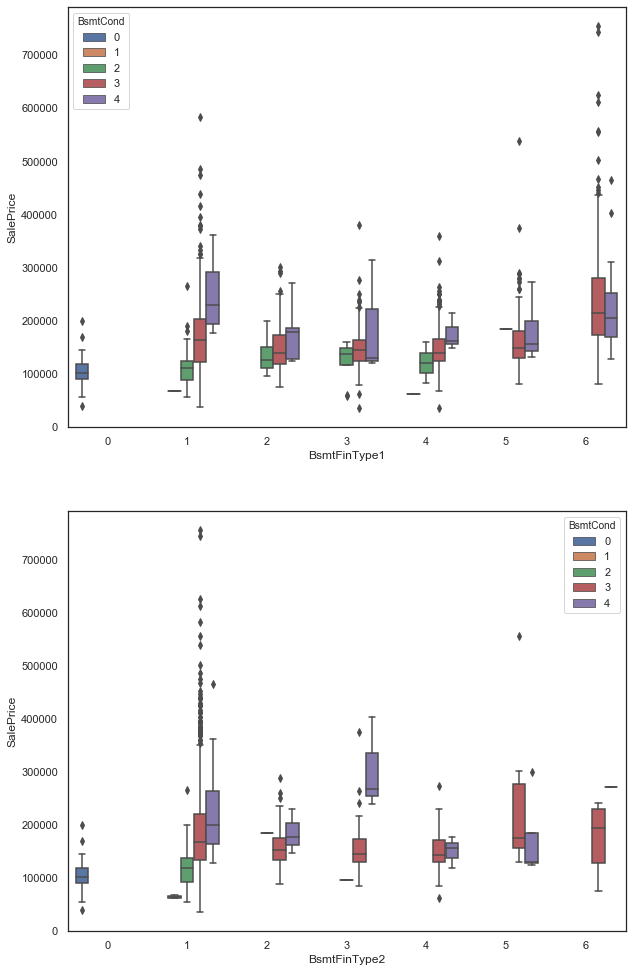

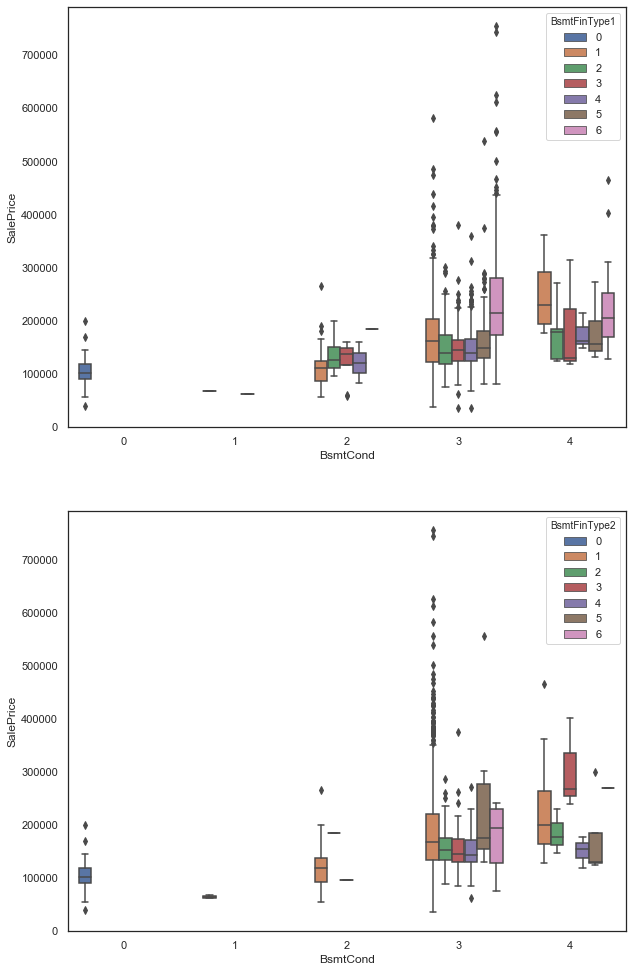

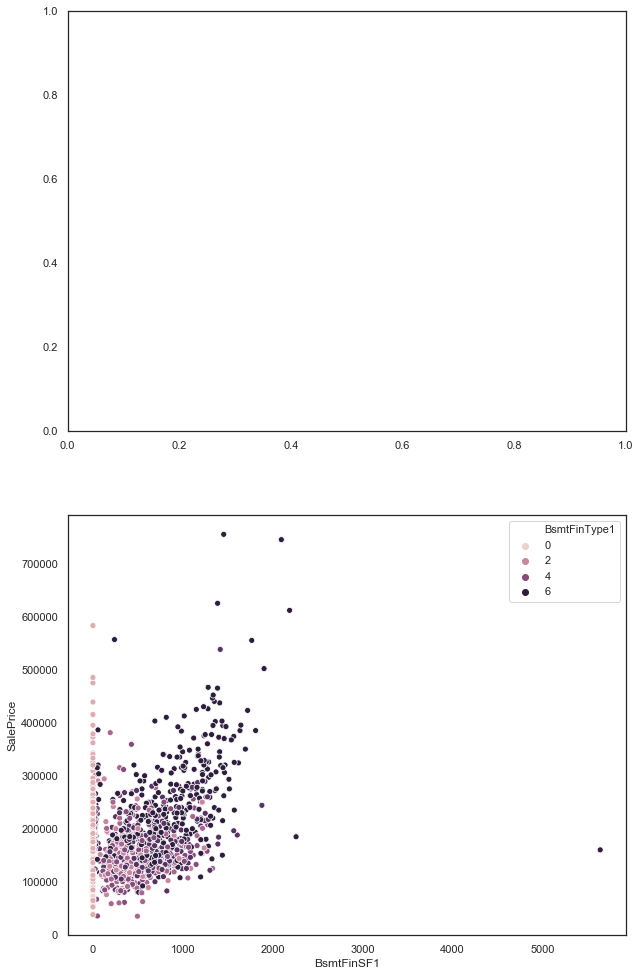

In [148]:
f, (ax1, ax2) =  plt.subplots(2, 1, figsize=(10, 17))
sns.boxplot(x="BsmtFinType1", y="SalePrice",
            hue="BsmtCond",
            data=all_data,
           ax=ax1)
sns.boxplot(x="BsmtFinType2", y="SalePrice",
            hue="BsmtCond",
            data=all_data,
            ax=ax2)
f, (ax1, ax2) =  plt.subplots(2, 1, figsize=(10, 17))
sns.boxplot(x="BsmtCond", y="SalePrice",
            hue="BsmtFinType1",
            data=all_data,
           ax=ax1)
sns.boxplot(x="BsmtCond", y="SalePrice",
            hue="BsmtFinType2",
            data=all_data,
            ax=ax2)
f, (ax1, ax2) =  plt.subplots(2, 1, figsize=(10, 17))
sns.stripplot(x="BsmtFinSF1",  y="BsmtFinType1", hue="BsmtFinSF1", data=all_data,
            ax=ax2)

## 5.1.4 Garage Variables

In [138]:
#
# from float type to int type
all_data.GarageYrBlt = all_data.GarageYrBlt.astype('Int64')
all_data[['GarageYrBlt','YearBuilt']]
_ = pd.DataFrame({'diff': all_data['GarageYrBlt']-all_data['YearBuilt']})

# print(f'Similarity GarageYrBlt and YearBuilt:{(_[ _["diff"]==0 ].count()/_.shape[0] *100)}%\n')

# Fillna by other field
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data['YearBuilt'])
all_data[['GarageYrBlt','YearBuilt']]

# all_data[['GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']]

# Since the missing rate of Garage* features are very similar, we may check if they have the phenomon -> the garage may not really exist
# Filter out one of the null field
set_159 = all_data[
#     all_data['GarageType'].isnull()
    all_data['GarageFinish'].isnull()
#     all_data['GarageCond'].isnull()&
#     all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


set_157 = all_data[
    all_data['GarageType'].isnull()&
    all_data['GarageFinish'].isnull()&
    all_data['GarageCond'].isnull()&
    all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


print(f'Bias Id: {set(set_159.Id) - set(set_157.Id)}')

# Seems 2127 has carage while 2577 no
set_159[(set_159.Id == 2577) | (set_159.Id == 2127) ]

# TODO Clean 2577
# all_data[all_data.Id==2577].GarageType
# Clean 2127
# all_data[all_data.Id==2127] = all_data[all_data.Id==2127].fillna(all_data.mode().iloc[0])

all_data.GarageCars = all_data.GarageType.fillna(0)
all_data.GarageArea = all_data.GarageType.fillna(0)

# Fill na to be factor
all_data.GarageType = all_data.GarageType.fillna('NoGarage')




# Convert the ordinal value
all_data.GarageFinish = convert_to_ordinary(all_data, [np.NaN, 'Unf', 'RFn', 'Fin'], 'GarageFinish')
all_data.GarageQual = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageQual')
all_data.GarageCond = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageCond')

Bias Id: {2577, 2127}
GarageFinish values: {nan, 'Fin', 'Unf', 'RFn'}
GarageQual values: {nan, 'Po', 'Gd', 'Fa', 'Ex', 'TA'}
GarageCond values: {nan, 'Po', 'Gd', 'Fa', 'Ex', 'TA'}


PoolQC values: {nan, 'Gd', 'Fa', 'Ex'}
Missing Fireplace is match: True
FireplaceQu values: {nan, 'Po', 'Gd', 'Fa', 'Ex', 'TA'}
Functional values: {'Sev', 'Mod', 'Min2', 'Maj2', 'Min1', 'Maj1', 'Typ'}
KitchenQual values: {'Fa', 'TA', 'Gd', 'Ex'}
Fence values: {nan, 'GdWo', 'MnPrv', 'GdPrv', 'MnWw'}


SalePrice       1459
Heating            0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
LandContour        0
MSSubClass         0
MSZoning           0
LotFrontage        0
LotArea            0
Street             0
Alley              0
LotShape           0
dtype: int64

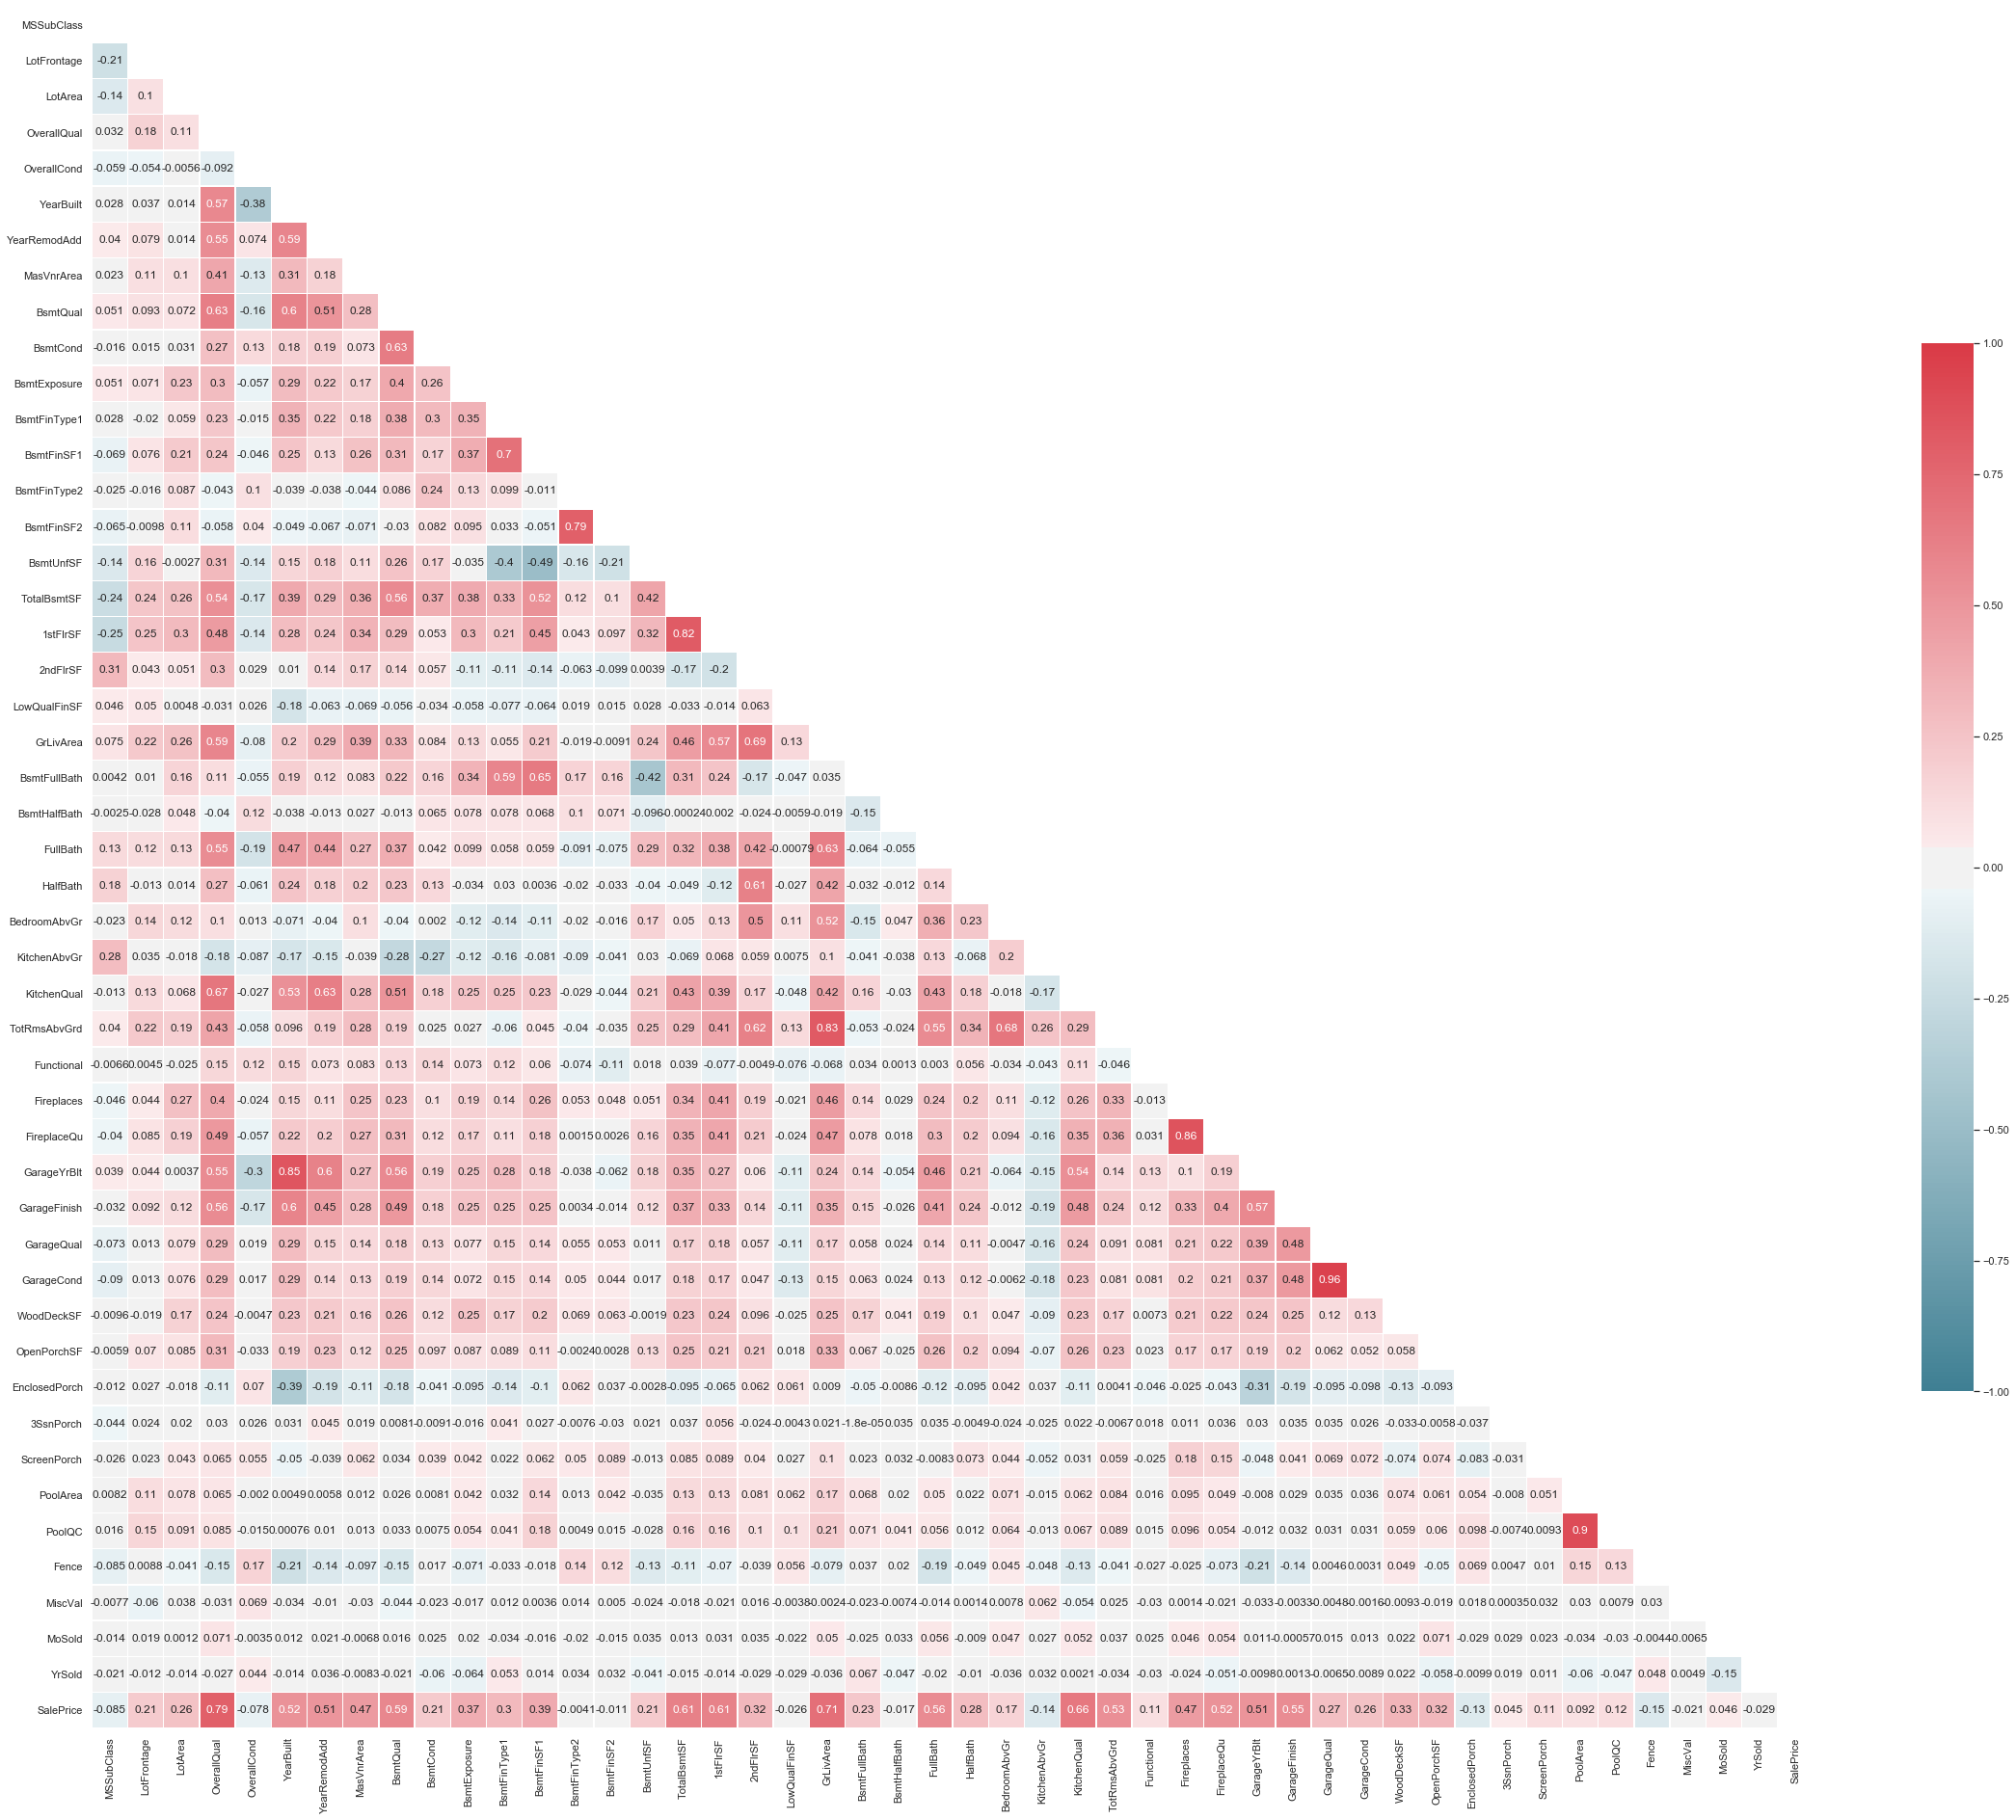

In [139]:



# encode this variable as the values are ordinal

# Check the PoolArea
all_data.PoolQC = convert_to_ordinary(all_data, [np.NaN, 'Fa', 'TA','Gd','Ex'], 'PoolQC')

# There are 3 records that have PoolArea but do not have PoolQC -> consider to use the linear regression for OverallQual and PoolQC
all_data[(all_data.PoolQC==0)& (all_data.PoolArea>0)][['PoolQC', 'PoolArea', 'OverallQual']]
# By plotting the chat, we can see the trend PoolQC is matched with OverallQual
# plot(y_field='OverallQual', x_field='PoolQC')


# Handling MiscFeature, to eliminate the None value for future processing
all_data.MiscFeature = all_data.MiscFeature.fillna('None')
# x = sns.barplot(x="MiscFeature", y="SalePrice", data=all_data)

# Within Fireplace Quality, there are 1420 NAs. Number of fireplaces is complete.
print(f'Missing Fireplace is match: {all_data.Fireplaces[all_data.Fireplaces==0].count() == len(all_data.FireplaceQu[all_data.FireplaceQu.isnull()])}')
all_data.FireplaceQu = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'FireplaceQu')


all_data['Functional'] = fillna_by_mode(all_data, field='Functional')
# all_data.Functional[all_data.Functional.isnull()
all_data.Functional = convert_to_ordinary(all_data, ['Sal', 'Sev', 'Maj2','Maj1','Mod','Min2','Min1','Typ'], 'Functional')
# plot('Functional')


all_data['SaleType'] = fillna_by_mode(all_data, field='SaleType')
# plot('SaleType')
# plot('SaleType')
# `KitchenAbvGr` is no NA nad 1NA in KitchenQual
len(all_data.KitchenQual[all_data.KitchenQual.isnull()])
all_data['KitchenQual'] = fillna_by_mode(all_data, field='KitchenQual')
all_data.KitchenQual = convert_to_ordinary(all_data, ['Po', 'Fa', 'TA','Gd','Ex'], 'KitchenQual')
all_data.KitchenAbvGr
# set(all_data.columns)
# plot(x_field='KitchenAbvGr')
# plot('KitchenQual')



# Since the NA is no pool -> convert to ordinary
all_data.Fence = convert_to_ordinary(all_data, [np.NaN, 'MnWw', 'GdWo','MnPrv','GdPrv'], 'Fence')
# plot('Fence')

# Electrical ->1 NA, fill by Mode
len(all_data.Electrical[all_data.Electrical.isnull()])
all_data['Electrical'] = fillna_by_mode(all_data, field='Electrical')
# plot('Electrical')

# all_data.Fence[all_data.Fence.isnull()]


display(all_data.apply(lambda column: column.isnull().sum(), axis=0).sort_values(ascending=False).head(30))
train_data_set = all_data[0:1459].copy()
train_data_set = train_data_set.drop(['Id'], axis=1)

plot_heap_map_corr(train_data_set)

# Label Encoding

## 5.1.1 MSSubClass

Categorical class is labeled as Number

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
       



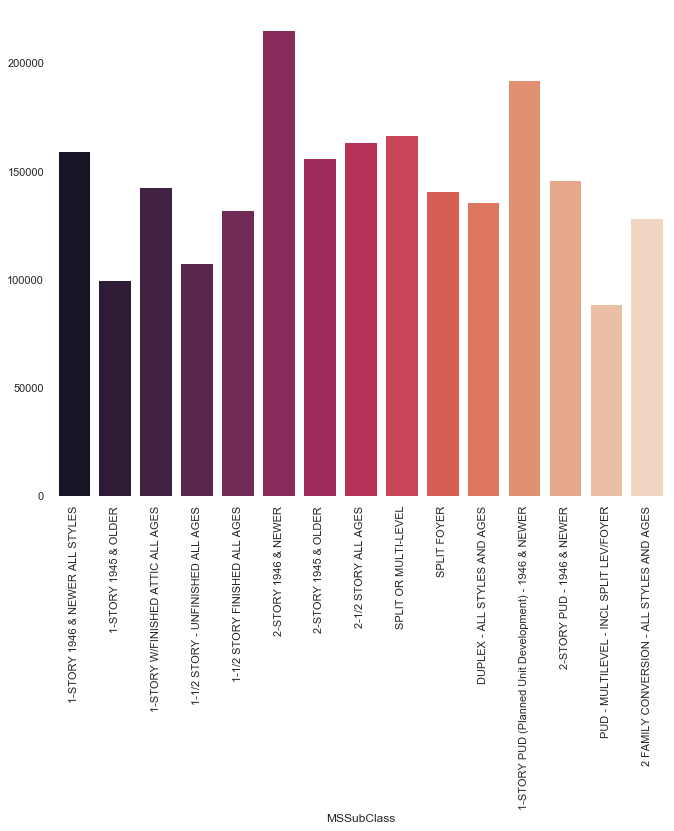

In [140]:

index_name= {
    20: '1-STORY 1946 & NEWER ALL STYLES',
    30: '1-STORY 1945 & OLDER',
    40: '1-STORY W/FINISHED ATTIC ALL AGES',
    45:'1-1/2 STORY - UNFINISHED ALL AGES',
    50:'1-1/2 STORY FINISHED ALL AGES',
    60:'2-STORY 1946 & NEWER',
    70:'2-STORY 1945 & OLDER',
    75:'2-1/2 STORY ALL AGES',
    80:'SPLIT OR MULTI-LEVEL',
    85:'SPLIT FOYER',
    90:'DUPLEX - ALL STYLES AND AGES',
    120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    150:'1-1/2 STORY PUD - ALL AGES',
    160:'2-STORY PUD - 1946 & NEWER',
    180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}

f, ax = plt.subplots(figsize=(11, 9))

# Get Median and Count Data
x = all_data['MSSubClass']
data = train_data.groupby('MSSubClass').SalePrice.agg(['median', 'count'])
# Rename Index for better information
data.rename(index=index_name, inplace=True)

sns.barplot(x=data.index, y=data['median'].values, palette="rocket", ax=ax)
plt.xticks(rotation=90)

sns.despine(left=True, bottom=True)

## LotArea
Check the relationship with LotFrontage,despit the similarity in name, they do not have much relationship.

In [141]:
all_data[['LotArea', 'LotFrontage']].corr()

,LotArea,LotFrontage
LotArea,1.000000,0.135246
LotFrontage,0.135246,1.000000
